<a href="https://colab.research.google.com/github/Saisha0512/Portfolio_Optimization_ML_DL/blob/main/Portfolio_Optimization_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problem Statement**

# **2. Data Collection**

In [97]:
# Installing the required libraries
!pip install yfinance

In [98]:

# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [99]:
# Fetching Data from yfinance
# Define the ticker symbols
tickers = ['AGG', 'VTI', 'DBC', '^VIX']  # Use '^VIX' for the volatility index

# Set the time period
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download OHLCV data
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.to_csv(f"{ticker}_historical_OHLCV_data.csv")
    data[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [100]:
# Displaying the AGG data
data['AGG'].head()

Price,Close,High,Low,Open,Volume
Ticker,AGG,AGG,AGG,AGG,AGG
Date,,,,,
2015-01-02,83.327927,83.380747,83.139282,83.139282,2090200
2015-01-05,83.509026,83.576940,83.365660,83.426022,3446200
2015-01-06,83.720322,84.022154,83.675049,83.727869,3688100
2015-01-07,83.705246,83.788250,83.561874,83.758066,3984400
2015-01-08,83.576927,83.637289,83.478829,83.637289,2212200


In [101]:
# Displaying the AGG data
data['DBC'].head()

Price,Close,High,Low,Open,Volume
Ticker,DBC,DBC,DBC,DBC,DBC
Date,,,,,
2015-01-02,15.931046,16.062129,15.887352,15.966002,1967300
2015-01-05,15.703833,15.861133,15.686356,15.861133,1827500
2015-01-06,15.555272,15.756268,15.511578,15.686357,1843100
2015-01-07,15.459145,15.607706,15.380494,15.537795,1868400
2015-01-08,15.520313,15.520313,15.363013,15.432924,1409400


In [102]:
# Displaying the AGG data
data['VTI'].head()

Price,Close,High,Low,Open,Volume
Ticker,VTI,VTI,VTI,VTI,VTI
Date,,,,,
2015-01-02,88.588005,89.257101,88.044365,89.064734,5298300
2015-01-05,87.065826,88.278563,86.865100,88.111285,5383500
2015-01-06,86.212715,87.400355,85.735986,87.316719,4226100
2015-01-07,87.241432,87.358523,86.605798,87.057430,3661500
2015-01-08,88.780365,88.855635,87.910542,87.994178,2796200


In [103]:
# Displaying the AGG data
data['^VIX'].head()

Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2015-01-02,17.790001,20.139999,17.049999,17.760000,0
2015-01-05,19.920000,21.290001,19.190001,19.190001,0
2015-01-06,21.120001,22.900000,19.520000,20.330000,0
2015-01-07,19.309999,20.719999,19.040001,20.150000,0
2015-01-08,17.010000,18.090000,16.990000,17.930000,0


# **3. Data Preprocessing**

In [104]:
# Reading all the CSV Files individually
agg = pd.read_csv("AGG_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
vti = pd.read_csv("VTI_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
dbc = pd.read_csv("DBC_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
vix = pd.read_csv("^VIX_historical_OHLCV_data.csv", index_col=0, parse_dates=True)

In [105]:
# Preprocessing Function for Each Asset
def preprocess_asset(df, asset_name):
    df = df.copy()

    # Convert relevant columns to numeric (errors='coerce' converts non-numeric to NaN)
    cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values
    df = df.ffill().bfill() # Forward & Backward filling

    # Sort by datetime
    df = df.sort_index()

    # Calculate features using 'Close'
    df['Daily Return'] = df['Close'].pct_change()
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std() * np.sqrt(252)

    # Add prefix to all columns
    df = df.add_prefix(f'{asset_name}_')

    return df

In [106]:
# Apply Preprocessing to Each Asset
agg_clean = preprocess_asset(agg, 'AGG')
vti_clean = preprocess_asset(vti, 'VTI')
dbc_clean = preprocess_asset(dbc, 'DBC')
vix_clean = preprocess_asset(vix, 'VIX')

In [107]:
agg_clean.head()

,AGG_Close,AGG_High,AGG_Low,AGG_Open,AGG_Volume,AGG_Daily Return,AGG_Cumulative Return,AGG_MA10,AGG_MA50,AGG_Rolling Volatility
Price,,,,,,,,,,
2015-01-02,83.327927,83.380747,83.139282,83.139282,2090200.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,83.509026,83.576940,83.365660,83.426022,3446200.0,0.002173,1.002173,NaN,NaN,NaN
2015-01-06,83.720322,84.022154,83.675049,83.727869,3688100.0,0.002530,1.004709,NaN,NaN,NaN
2015-01-07,83.705246,83.788250,83.561874,83.758066,3984400.0,-0.000180,1.004528,NaN,NaN,NaN
2015-01-08,83.576927,83.637289,83.478829,83.637289,2212200.0,-0.001533,1.002988,NaN,NaN,NaN


In [108]:
vti_clean.head()

,VTI_Close,VTI_High,VTI_Low,VTI_Open,VTI_Volume,VTI_Daily Return,VTI_Cumulative Return,VTI_MA10,VTI_MA50,VTI_Rolling Volatility
Price,,,,,,,,,,
2015-01-02,88.588005,89.257101,88.044365,89.064734,5298300.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,87.065826,88.278563,86.865100,88.111285,5383500.0,-0.017183,0.982817,NaN,NaN,NaN
2015-01-06,86.212715,87.400355,85.735986,87.316719,4226100.0,-0.009798,0.973187,NaN,NaN,NaN
2015-01-07,87.241432,87.358523,86.605798,87.057430,3661500.0,0.011932,0.984800,NaN,NaN,NaN
2015-01-08,88.780365,88.855635,87.910542,87.994178,2796200.0,0.017640,1.002171,NaN,NaN,NaN


In [109]:
dbc_clean.head()

,DBC_Close,DBC_High,DBC_Low,DBC_Open,DBC_Volume,DBC_Daily Return,DBC_Cumulative Return,DBC_MA10,DBC_MA50,DBC_Rolling Volatility
Price,,,,,,,,,,
2015-01-02,15.931046,16.062129,15.887352,15.966002,1967300.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,15.703833,15.861133,15.686356,15.861133,1827500.0,-0.014262,0.985738,NaN,NaN,NaN
2015-01-06,15.555272,15.756268,15.511578,15.686357,1843100.0,-0.009460,0.976413,NaN,NaN,NaN
2015-01-07,15.459145,15.607706,15.380494,15.537795,1868400.0,-0.006180,0.970379,NaN,NaN,NaN
2015-01-08,15.520313,15.520313,15.363013,15.432924,1409400.0,0.003957,0.974218,NaN,NaN,NaN


In [110]:
vix_clean.head()

,VIX_Close,VIX_High,VIX_Low,VIX_Open,VIX_Volume,VIX_Daily Return,VIX_Cumulative Return,VIX_MA10,VIX_MA50,VIX_Rolling Volatility
Price,,,,,,,,,,
2015-01-02,17.790001,20.139999,17.049999,17.760000,0.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,19.920000,21.290001,19.190001,19.190001,0.0,0.119730,1.119730,NaN,NaN,NaN
2015-01-06,21.120001,22.900000,19.520000,20.330000,0.0,0.060241,1.187184,NaN,NaN,NaN
2015-01-07,19.309999,20.719999,19.040001,20.150000,0.0,-0.085701,1.085441,NaN,NaN,NaN
2015-01-08,17.010000,18.090000,16.990000,17.930000,0.0,-0.119109,0.956155,NaN,NaN,NaN


In [111]:
# Merge All Cleaned Data into One DataFrame
# Join on index (Date)
df_all = agg_clean.join([vti_clean, dbc_clean, vix_clean], how='inner')
df_all.dropna(inplace=True)  # Drop rows with incomplete feature sets

print(df_all.head())

            AGG_Close   AGG_High    AGG_Low   AGG_Open  AGG_Volume  \
Price                                                                
2015-03-16  83.712021  83.780151  83.590894  83.742303   1305800.0   
2015-03-17  83.696915  83.787760  83.681777  83.757478   1423700.0   
2015-03-18  84.310059  84.325197  83.712007  83.870982   1997800.0   
2015-03-19  84.014877  84.257126  83.984596  84.211700   1929700.0   
2015-03-20  84.272194  84.287332  84.166211  84.204064   3833600.0   

            AGG_Daily Return  AGG_Cumulative Return   AGG_MA10   AGG_MA50  \
Price                                                                       
2015-03-16          0.002175               1.004609  83.496280  83.896132   
2015-03-17         -0.000180               1.004428  83.515206  83.903512   
2015-03-18          0.007326               1.011786  83.590905  83.919532   
2015-03-19         -0.003501               1.008244  83.633300  83.925423   
2015-03-20          0.003063               1.01

In [112]:
# Normalize or Scale for ML Models
from sklearn.preprocessing import StandardScaler

# Select only relevant features to scale (not raw prices)
features_to_scale = [
    col for col in df_all.columns
    if 'Daily Return' in col or 'Cumulative Return' in col or 'Volatility' in col
]

# Initialize scaler
scaler = StandardScaler()

# Scale only those features
scaled_subset = pd.DataFrame(
    scaler.fit_transform(df_all[features_to_scale]),
    columns=features_to_scale,
    index=df_all.index
)

# Merge back into original DataFrame (keeping unscaled features)
df_scaled = df_all.copy()
df_scaled[features_to_scale] = scaled_subset

# Preview
print(df_scaled.head())

            AGG_Close   AGG_High    AGG_Low   AGG_Open  AGG_Volume  \
Price                                                                
2015-03-16  83.712021  83.780151  83.590894  83.742303   1305800.0   
2015-03-17  83.696915  83.787760  83.681777  83.757478   1423700.0   
2015-03-18  84.310059  84.325197  83.712007  83.870982   1997800.0   
2015-03-19  84.014877  84.257126  83.984596  84.211700   1929700.0   
2015-03-20  84.272194  84.287332  84.166211  84.204064   3833600.0   

            AGG_Daily Return  AGG_Cumulative Return   AGG_MA10   AGG_MA50  \
Price                                                                       
2015-03-16          0.523761              -1.336423  83.496280  83.896132   
2015-03-17         -0.045506              -1.338885  83.515206  83.903512   
2015-03-18          1.768457              -1.238939  83.590905  83.919532   
2015-03-19         -0.847987              -1.287056  83.633300  83.925423   
2015-03-20          0.738251              -1.24

In [113]:
# Saving the Normalized Data to a CSV File
df_scaled.to_csv("Normalized_Preprocessed_Combined_Data.csv")

print("Final Normalized & Combined Data is saved to 'Normalized_Preprocessed_Combined_Data.csv'")

Final Normalized & Combined Data is saved to 'Normalized_Preprocessed_Combined_Data.csv'


# **4. EDA**

In [114]:
# Loading the final processed data
df = pd.read_csv("Normalized_Preprocessed_Combined_Data.csv", index_col=0, parse_dates=True)

# Preview data
print(df.head())

            AGG_Close   AGG_High    AGG_Low   AGG_Open  AGG_Volume  \
Price                                                                
2015-03-16  83.712021  83.780151  83.590894  83.742303   1305800.0   
2015-03-17  83.696915  83.787760  83.681777  83.757478   1423700.0   
2015-03-18  84.310059  84.325197  83.712007  83.870982   1997800.0   
2015-03-19  84.014877  84.257126  83.984596  84.211700   1929700.0   
2015-03-20  84.272194  84.287332  84.166211  84.204064   3833600.0   

            AGG_Daily Return  AGG_Cumulative Return   AGG_MA10   AGG_MA50  \
Price                                                                       
2015-03-16          0.523761              -1.336423  83.496280  83.896132   
2015-03-17         -0.045506              -1.338885  83.515206  83.903512   
2015-03-18          1.768457              -1.238939  83.590905  83.919532   
2015-03-19         -0.847987              -1.287056  83.633300  83.925423   
2015-03-20          0.738251              -1.24

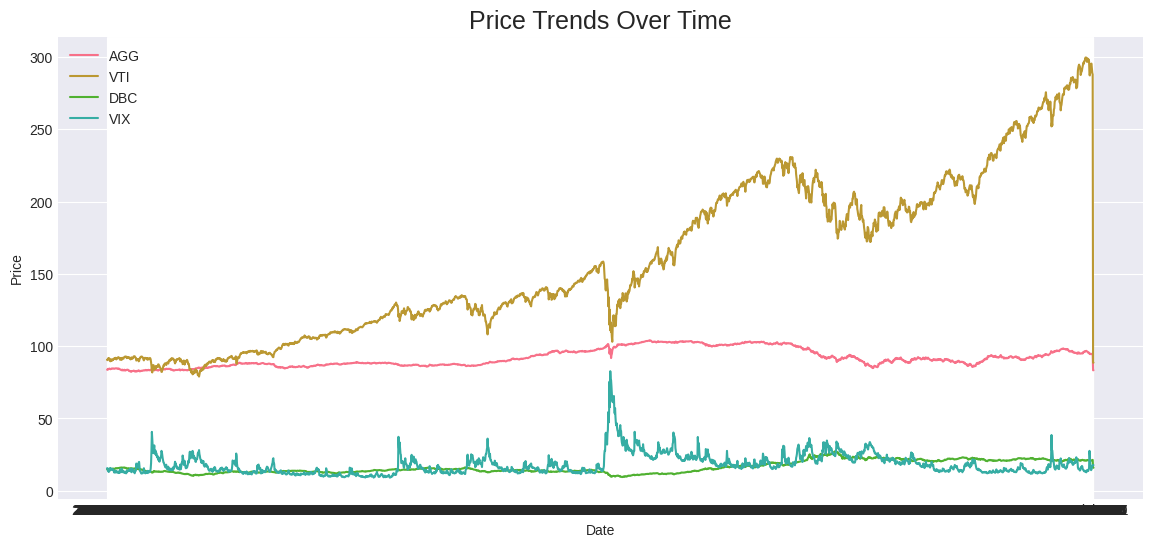

In [116]:
# Plotting the Price Trends Over Time
plt.figure(figsize=(14, 6))

for asset in ['AGG', 'VTI', 'DBC', 'VIX']:
    plt.plot(df[f'{asset}_Close'], label=asset)

plt.title("Price Trends Over Time", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

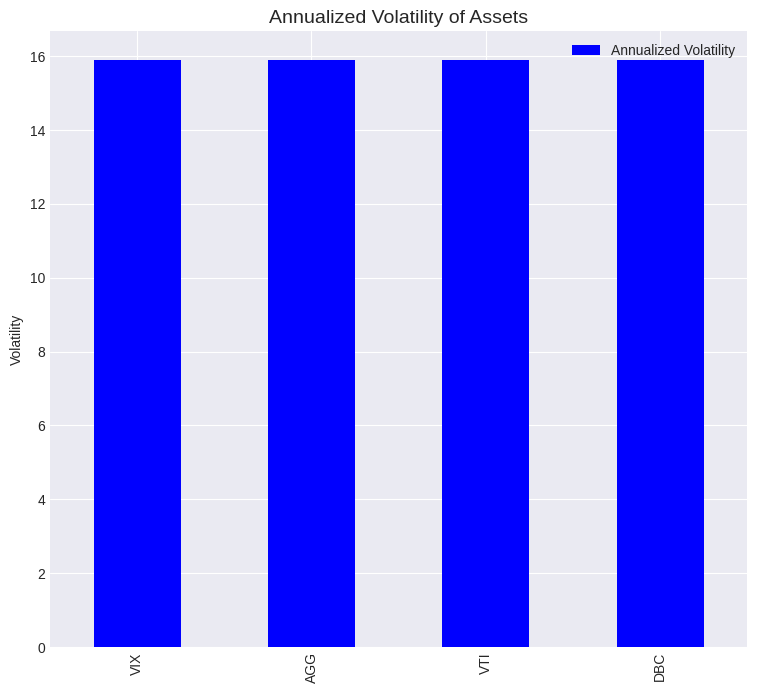

In [128]:
# Plotting the Volatility (Standard Deviation of Daily Returns)
volatility = {
    asset: df[f'{asset}_Daily Return'].std() * np.sqrt(252)  # annualized
    for asset in ['AGG', 'VTI', 'DBC', 'VIX']
}

vol_df = pd.DataFrame.from_dict(volatility, orient='index', columns=['Annualized Volatility'])
vol_df.sort_values('Annualized Volatility', ascending=False).plot(kind='bar', figsize=(9, 8), color='blue')
plt.title("Annualized Volatility of Assets", fontsize=14)
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

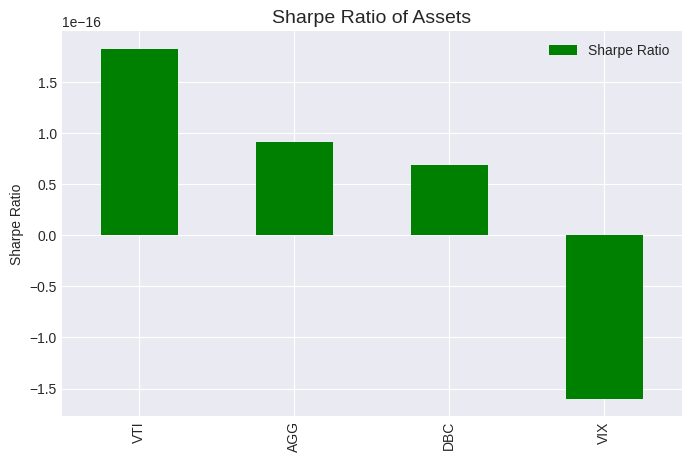

In [124]:
# Plotting the Sharpe Ratio
sharpe_ratios = {
    asset: df[f'{asset}_Daily Return'].mean() / df[f'{asset}_Daily Return'].std() * np.sqrt(252)
    for asset in ['AGG', 'VTI', 'DBC', 'VIX']
}

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_df.sort_values('Sharpe Ratio', ascending=False).plot(kind='bar', figsize=(8, 5), color='green')
plt.title("Sharpe Ratio of Assets", fontsize=14)
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()


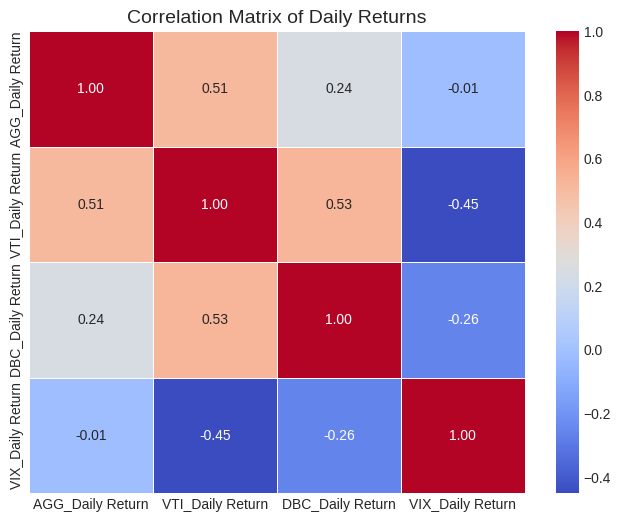

In [129]:
# Plotting the Correlation Matrix (Daily Returns)
returns_df = df[[f'{asset}_Daily Return' for asset in ['AGG', 'VTI', 'DBC', 'VIX']]]
corr = returns_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Daily Returns", fontsize=14)
plt.show()

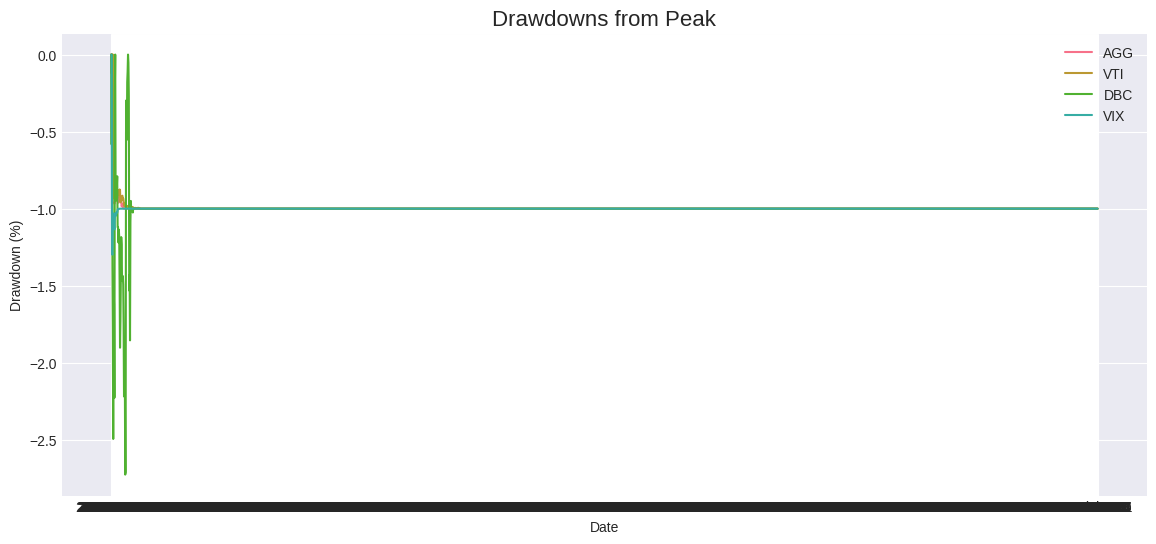

In [130]:
# Plotting the Drawdown (Max Loss from Peak)
def calculate_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown

plt.figure(figsize=(14, 6))
for asset in ['AGG', 'VTI', 'DBC', 'VIX']:
    drawdown = calculate_drawdown(df[f'{asset}_Daily Return'])
    plt.plot(drawdown, label=asset)
plt.title("Drawdowns from Peak", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.show()


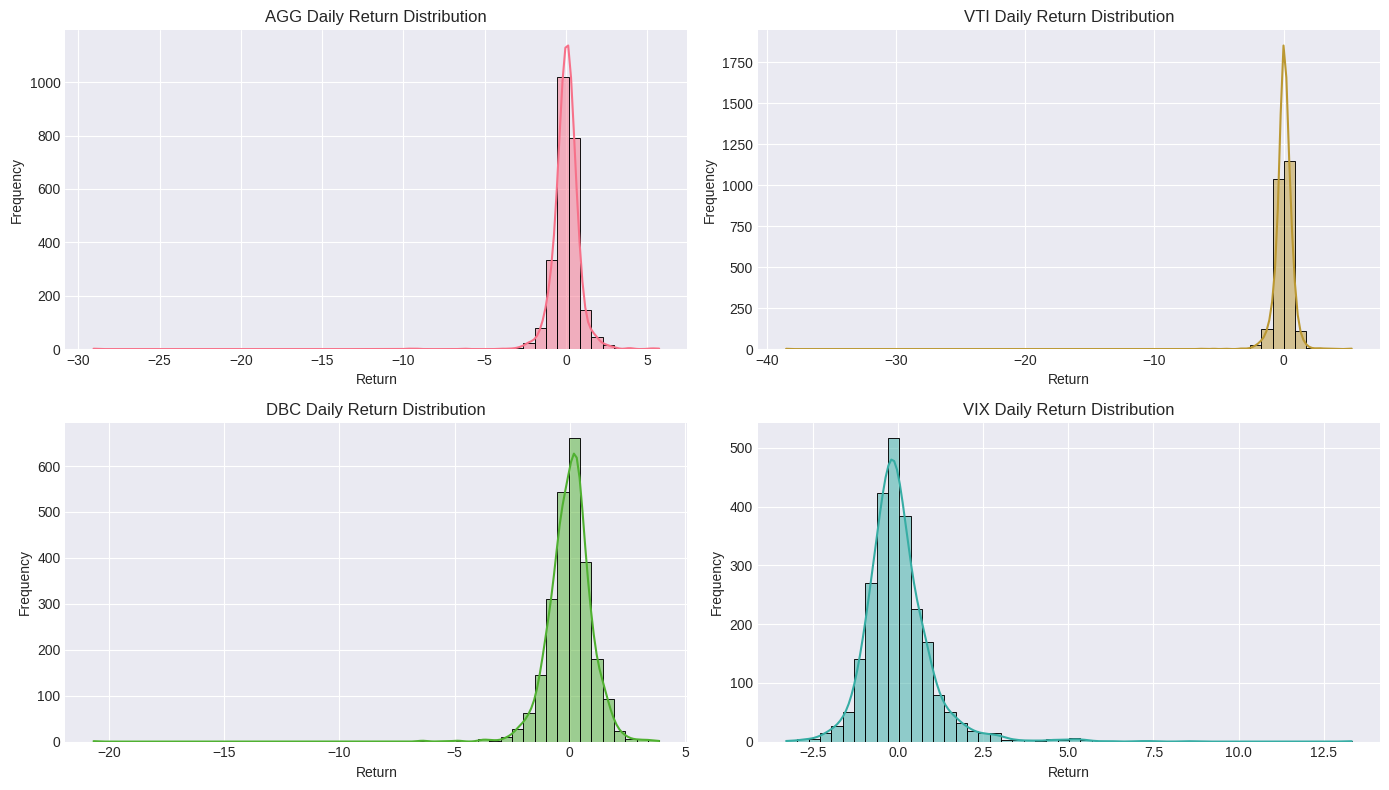

In [132]:
# Plotting the Histograms of Return Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
assets = ['AGG', 'VTI', 'DBC', 'VIX']

for i, asset in enumerate(assets):
    sns.histplot(df[f'{asset}_Daily Return'], bins=50, kde=True, ax=axes[i], color=sns.color_palette()[i])
    axes[i].set_title(f"{asset} Daily Return Distribution", fontsize=12)
    axes[i].set_xlabel("Return")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# **5. Feature Engineering**

# **6. Portfolio Optimization**

# **7. Machine Learning**

# **8. Deep Learning for Trend Prediction**